# Introduction
The objective of this notebook is to set up a simple time series forecast process in Python 3. This is based on: Jason Brownlee (2018) Deep Learning for Time Series Forecasting, Predict the Future with MLPs, CNNs and LSTMs in Python.

Key steps are:
1. Set up training and testing
2. Read in time series data
3. Define a function to evaluate forecast accuracy
4. Develop a naive forecast model for one day ahead, one week ahead & week forecast from the year before.


# Set up training and testing

In [3]:
# create a function to split a univariate dataset into train/test sets
def split_dataset(data):
    from numpy import split
    from numpy import array
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

*Note*: the function above uses split to create segments of seven day sub-arrays. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.split.html. A simple example is shown below:

In [67]:
import numpy as np
x = np.arange(21.0)
print(x)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.]


In [69]:
np.split(x, len(x)/7)

[array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 array([  7.,   8.,   9.,  10.,  11.,  12.,  13.]),
 array([ 14.,  15.,  16.,  17.,  18.,  19.,  20.])]

End of example

In [5]:
# load the data
from pandas import read_csv
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)

In [51]:
type(dataset)


pandas.core.frame.DataFrame

In [33]:
print(dataset[-328:-327]) # print the last row of training set

            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2010-01-03             2083.454                 191.61  350992.12   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2010-01-03            8703.6          3842.0          4920.0         10074.0   

               remainder     Remainder  
datetime                                
2010-01-03  15888.233333  15888.233333  


In [74]:
print(dataset[1:2]) # print the second row of dataset

            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-17              3390.46                226.006  345725.32   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-17           14398.6          2033.0          4187.0         13341.0   

               remainder     Remainder  
datetime                                
2006-12-17  36946.666667  36946.666667  


In [77]:
print(train[0,0,0]) # [0, 0, 0] corresponds to [week number, day of week, variable]; 
# print the first element of the first variable in the first week in the training data

3390.46


In [81]:
print(train[1,0,1]) # [1, 0, 1] corresponds to [week, day of week, variable]; 
# print the first day of the second variable (Global_reactive_power) in the second week in the training data

149.9


In [82]:
print(dataset[8:9]) # print the 8th row of dataset, which corresponds to the cell above. 
# Verify that the value for Global_reactive_power matches the result from the cell above.

            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-24             2550.012                  149.9  348029.91   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-24           11002.2          1703.0          5082.0          6891.0   

            remainder  Remainder  
datetime                          
2006-12-24    28824.2    28824.2  


In [53]:
# validate train data
print(train.shape)
print(train[0, 0, 0], test[-1, -1, 0])

# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 9)
3390.46 2197.006
(46, 7, 9)
2083.454 2197.006


The results of the cell above show that there are 159 weeks of data in the training set, split into weekly segments of seven days, across 9 variables i.e. (159, 7, 9). This is compared to the validation data set, which has 46 weeks split into seven day segments, across 9 variables.

# Define a function to evaluate forecast accuracy

In [101]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    from math import sqrt
    from sklearn.metrics import mean_squared_error
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mean square error (mse)
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate root mse (rmse)
        rmse = sqrt(mse)
        # store the calculated value
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s +=(actual[row, col] - predicted[row, col])**2
    score = sqrt(s/ (actual.shape[0] * actual.shape[1]))
    return score, scores

# Define a function to validate the forecast model

In [95]:
# evaluate a single model using the walk-forward validation approach
def evaluate_model(model_func, train, test):
    from numpy import array
    # history is a list of weekly data
    history = [x for x in train] # this is a list comprehension that creates a list from an array
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = model_func(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [86]:
type(history)

list

In [87]:
type(train)

numpy.ndarray

In [103]:
# create a summary of the scores
def summarise_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# Develop naive forecast models


In [89]:
# create a daily persistence forecast model
def daily_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    # get the total active power for the lst day
    value = last_week[-1, 0]
    # prepare 7 day forecast
    forecast = [value for _ in range(7)]
    return forecast

In [90]:
# create a weekly persistence forecast model
def weekly_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    return last_week[:, 0]


In [91]:
# create a weekly one year ago forecast model
def week_one_year_ago_persistence(history):
    # get the data for the prior week
    last_week = history[-52]
    return last_week[:, 0]

Create a dictionary to store the model names

In [93]:
# define the names and functions for the models to be evaluated
models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-oya'] = week_one_year_ago_persistence

# Fit and evaluate forecast models

daily_persistence: [511.886] 452.9, 596.4, 532.1, 490.5, 534.3, 481.5, 482.0
daily_persistence: [469.389] 567.6, 500.3, 411.2, 466.1, 471.9, 358.3, 482.0
daily_persistence: [465.294] 550.0, 446.7, 398.6, 487.0, 459.3, 313.5, 555.1


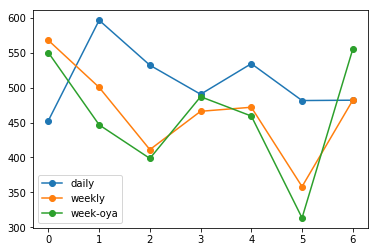

In [109]:
# evaluate each model
from matplotlib import pyplot
# days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = range(0, 7)
for name, func in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
    # summarise scores
    summarise_scores('daily_persistence', score, scores)
    # plot scores
    pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()

The chart shown above shows the forecast error statistic for each day of the daily and weekly forecast. The plot and the table of results shown above the chart suggest that the one week ahead a year ago is the more accurate forecast method.

End of notebook.